In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
download = drive.CreateFile({'id': '1sRUp_jnLMUTBNDiWZYy_qKjjiorDcOt9'})
download.GetContentFile('data.zip')
!unzip data.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008620.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008621.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008622.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008626.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008627.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008628.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008629.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008630.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008632.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008633.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008634.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008636.jpg  
  inflating: data_test/Ford F-450 Super Duty Crew Cab 2012/008637.jpg  
  inflating: data_test/Ford F-450 Super Dut

In [4]:
from google.colab import drive
drive.mount('test')

Mounted at test


In [5]:
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
import os, random, shutil


def make_dir(source, target):
    '''
    创建和源文件相似的文件路径函数
    :param source: 源文件位置
    :param target: 目标文件位置
    '''
    dir_names = os.listdir(source)
    for names in dir_names:
        for i in ['train', 'valid', 'test']:
            path = target + '/' + i + '/' + names
            if not os.path.exists(path):
                os.makedirs(path)


def divideTrainValiTest(source, target):
    '''
        创建和源文件相似的文件路径
        :param source: 源文件位置
        :param target: 目标文件位置
    '''
    # 得到源文件下的种类
    pic_name = os.listdir(source)
    
    # 对于每一类里的数据进行操作
    for classes in pic_name:
        # 得到这一种类的图片的名字
        pic_classes_name = os.listdir(os.path.join(source, classes))
        random.shuffle(pic_classes_name)
        
        # 按照8：1：1比例划分
        train_list = pic_classes_name[0:int(0.9 * len(pic_classes_name))]
        valid_list = pic_classes_name[int(0.9 * len(pic_classes_name)):]
        test_list = pic_classes_name[int(0.9 * len(pic_classes_name)):]
        
        # 对于每个图片，移入到对应的文件夹里面
        for train_pic in train_list:
            shutil.copyfile(source + '/' + classes + '/' + train_pic, target + '/train/' + classes + '/' + train_pic)
        for validation_pic in valid_list:
            shutil.copyfile(source + '/' + classes + '/' + validation_pic,
                            target + '/valid/' + classes + '/' + validation_pic)
        for test_pic in test_list:
            shutil.copyfile(source + '/' + classes + '/' + test_pic, target + '/test/' + classes + '/' + test_pic)



if __name__ == '__main__':
    filepath = r'data_test'
    dist = r'data'
    make_dir(filepath, dist)
    divideTrainValiTest(filepath, dist)

In [61]:
# Training transform includes random rotation and flip to build a more robust model
train_transforms = transforms.Compose([transforms.Resize((244,244)), transforms.RandomCrop(200, padding=0), transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# The validation set will use the same transform as the test set
test_transforms = transforms.Compose([transforms.Resize((244,244)),transforms.Resize((244,244)),lass transforms.RandomCrop(200, padding=0), transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=2),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validation_transforms = transforms.Compose([transforms.Resize((244,244)),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=validation_transforms)

# Using the image datasets and the trainforms, define the dataloaders
# The trainloader will have shuffle=True so that the order of the images do not affect the model
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True)

In [62]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01, amsgrad=False)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [63]:
import torch as th                                                                 
                                                                                  
class NLL_OHEM(th.nn.NLLLoss):                                                     
    """ Online hard example mining. 
    Needs input from nn.LogSotmax() """                                             
                                                                                   
    def __init__(self, ratio):      
        super(NLL_OHEM, self).__init__(None, True)                                 
        self.ratio = ratio                                                         
                                                                                   
    def forward(self, x, y, ratio=None):                                           
        if ratio is not None:                                                      
            self.ratio = ratio                                                     
        num_inst = x.size(0)                                                       
        num_hns = int(self.ratio * num_inst)                                       
        x_ = x.clone()                                                             
        inst_losses = th.autograd.Variable(th.zeros(num_inst)).cuda()              
        for idx, label in enumerate(y.data):                                       
            inst_losses[idx] = -x_.data[idx, label]                                 
        #loss_incs = -x_.sum(1)                                                    
        _, idxs = inst_losses.topk(num_hns)                                        
        x_hn = x.index_select(0, idxs)                                             
        y_hn = y.index_select(0, idxs)                                             
        return th.nn.functional.nll_loss(x_hn, y_hn)

In [34]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    
    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):
      
        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.exp(output)
        
        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return valid_loss, accuracy

In [ ]:
print(model)

In [1]:
epochs = 10
steps = 0
print_every = 40

# change to gpu mode
model.to('cuda')
model.train()
for e in range(epochs):

    running_loss = 0
    
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        # zeroing parameter gradients
        optimizer.zero_grad()
        
        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        print(loss)
        a = NLL_OHEM(loss)
        a.forward(trainloader,validloader)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()
            
            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)
            
            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")
            
            
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)

NameError: ignored

In [52]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 82.377%


In [20]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"/train")

print(classes, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [56]:
from keras.preprocessing import image
from torchvision import transforms
#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([transforms.Resize((244,244)),
                                      #  transforms.RandomRotation(30),
                                      #  transforms.RandomHorizontalFlip(p=0.4),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
a = []
te = []
for i in range(0,16182):
    print(i)
    if os.path.exists('test/My Drive/testing_data/'+str(i).zfill(6)+'.jpg'):
      te.append(i)
      img = image.load_img('test/My Drive/testing_data/'+str(i).zfill(6)+'.jpg', grayscale=False)
      img_preprocessed = preprocess(img)
      batch_img_cat_tensor = torch.unsqueeze(img_preprocessed, 0)
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      batch_img_cat_tensor = batch_img_cat_tensor.to(device)
      model.eval()
      out = model(batch_img_cat_tensor)
      _, index = torch.max(out, 1)
      percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
      a.append(classes[index[0]])

串流輸出內容已截斷至最後 5000 行。
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240
11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
1

In [24]:
import csv
with open('answer.csv', 'w', newline='') as csvFile:
  # 建立 CSV 檔寫入器
  writer = csv.writer(csvFile)

  writer = csv.writer(csvFile, delimiter=',')

  # 寫出標題
  writer.writerow(['id','label'])

In [57]:
import pandas as pd
sample = pd.read_csv('answer.csv')
sample['id'] = te
sample['label'] = a
sample.to_csv('sample_cnn.csv', header=True, index=False)

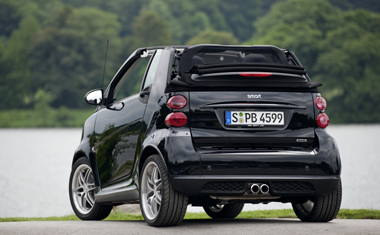

In [17]:
from PIL import Image
img_cat = Image.open("test/My Drive/testing_data/016172.jpg").convert('RGB')
img_cat

In [18]:
from torchvision import transforms
preprocess = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]) 
img_cat_preprocessed = preprocess(img_cat)

In [53]:
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_img_cat_tensor = batch_img_cat_tensor.to(device)
model.eval()
outputs = model.forward(batch_img_cat_tensor)
out = model(batch_img_cat_tensor)
_, index = torch.max(outputs, 1)
index
percentage = torch.nn.functional.softmax(outputs, dim=1)[0] * 100
print(classes[index[0]], percentage[index[0]].item())

Ford Expedition EL SUV 2009 11.531392097473145
